# **Acquiring dataset and exploratory data analysis**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Importing dependencies
import numpy as np
import PIL
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
import tensorflow as tf
from tensorflow.keras import layers # False warning
import csv
import cv2
import pandas as pd

!pip install silence_tensorflow
import silence_tensorflow.auto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4475 sha256=61a7eb9cdb78fab65f46799f69d7da44aaf0dbfb8f1e8733cb55277bf1867496
  Stored in directory: /root/.cache/pip/wheels/d6/ec/29/1ed23ae577b310931b534a6da0aa3adc169deef9a8ef10bd26
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5651 sha256=10bcf0ec4eb3dc017c37b2511d7d12fbdf552998bade7e9cf38b74fd97f2ae9f
  Stored in directory: /root/.cache/pip/wheels/7c/a1/b1/9662c79502c353ff7e71c36f84846acd623cbcbe3f7255f5d5
Successfully built silence_tensorflow support_developer


In [2]:
# Downloading dataset
!gdown "https://drive.google.com/uc?id=1fSu9gWbu4MOf7N9u7ir9D5Z6xbKJJnZp&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1fSu9gWbu4MOf7N9u7ir9D5Z6xbKJJnZp&confirm=t
To: /content/GTSRB_dataset.zip
100% 642M/642M [00:10<00:00, 58.6MB/s]


In [3]:
# Extracting dataset
with ZipFile("GTSRB_dataset.zip", 'r') as zip:
    print('Extracting all the files now...')
    zip.extractall('/content/GTSRB_dataset')
    zip.close()
    print('Extraction done!')

Extracting all the files now...
Extraction done!


In [4]:
# Modifying class names for actual labels
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

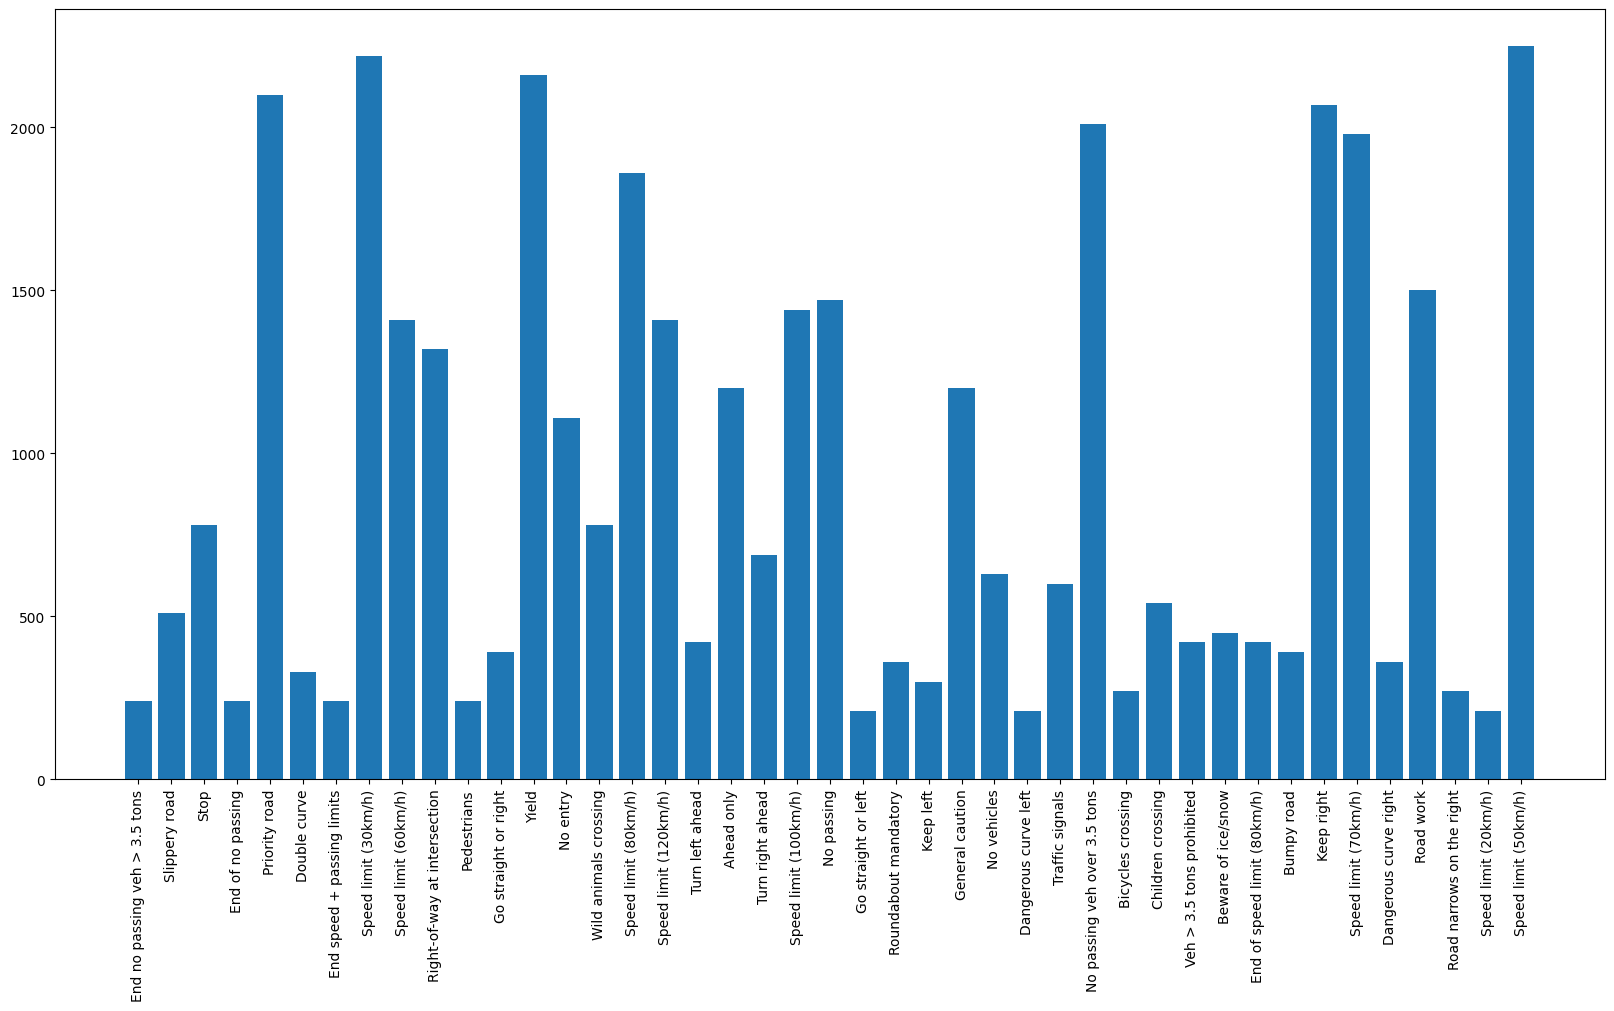

In [11]:
# Showing the distribution of the different classes
DATASET_PATH = '/content/GTSRB_dataset'
TRAIN_SET_PATH = '/content/GTSRB_dataset/Train'
TEST_SET_PATH = '/content/GTSRB_dataset/Test'
folders = os.listdir(TRAIN_SET_PATH)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(TRAIN_SET_PATH + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Plotting the number of images in each class
plt.figure(figsize=(20,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

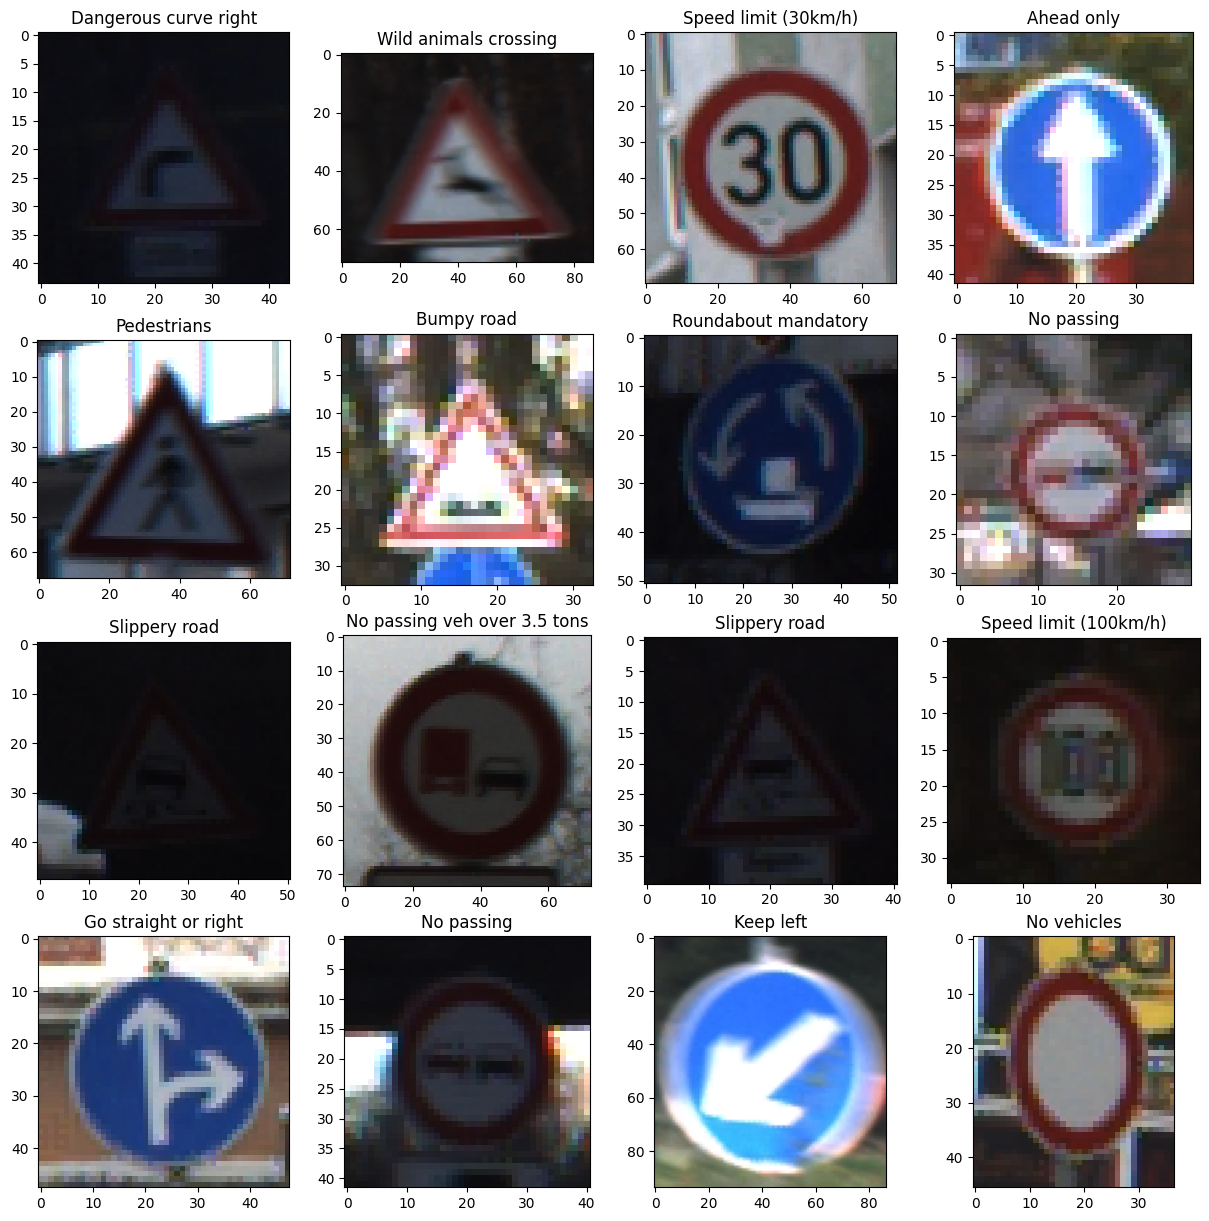

In [6]:
T# Showing sample images
np.random.seed(42)
fig = plt.figure(figsize=(15, 15))
num_of_classes = len(os.listdir(TRAIN_SET_PATH))

for i in range(1, 4*4 +1):
    rand_class = np.random.randint(num_of_classes)
    class_numbers = os.listdir('/content/GTSRB_dataset/Train')
    rand_folder = os.listdir('/content/GTSRB_dataset/Train/' + class_numbers[rand_class])
    ax = fig.add_subplot(4, 4, i)
    img = np.array(PIL.Image.open('/content/GTSRB_dataset/Train/' + str(class_numbers[rand_class]) + '/' + np.random.choice(rand_folder)))
    plt.imshow(img)
    ax.set_title(str(classes[int(class_numbers[rand_class])]))
plt.show()

In [7]:
# Defining parameters for data loading
TRAIN_BATCH_SIZE = 256
IMG_HEIGHT = 40
IMG_WIDTH = 40

VAL_BATCH_SIZE = 256
VAL_SPLIT_RATIO = 0.2

TEST_BATCH_SIZE = 256

In [24]:
# Loading training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_SET_PATH,
    validation_split = VAL_SPLIT_RATIO,
    subset = "training",
    seed=123,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = (TRAIN_BATCH_SIZE)
)

# Loading training validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_SET_PATH,
    validation_split = VAL_SPLIT_RATIO,
    subset = "validation",
    seed=123,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = (VAL_BATCH_SIZE)
)

# Loading test set
test_csv = pd.read_csv('/content/GTSRB_dataset/Test.csv')
test_labels = (test_csv["ClassId"].values).tolist()
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_SET_PATH,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = (TEST_BATCH_SIZE),
    labels = test_labels
)

# train_ds_iterator = train_ds.as_numpy_iterator()
# batch = train_ds_iterator.next()

# fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
# for idx, img in enumerate(batch[0][:4]):
#   ax[idx].imshow(img.astype(int))
#   ax[idx].title.set_text(batch[1][idx])

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.
Found 12630 files belonging to 43 classes.


In [19]:
AUG_MULT = 1

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.02),
    layers.RandomZoom(height_factor=(-0.2, -0.3)),
    layers.RandomContrast(factor=0.2),
    layers.RandomBrightness(factor=0.2)
])

def augmentation(ds):
  AUTOTUNE = tf.data.AUTOTUNE
  ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds_aug = augmentation(train_ds)
# for iter in range(AUG_MULT):
#   aug_ds = augmentation(train_ds)
#   train_ds_aug_concat = train_ds_aug.concatenate(aug_ds)
# train_ds_aug_iterator = train_ds_aug_concat.as_numpy_iterator()
# batch = train_ds_aug_iterator.next()

# train_ds_aug = train_ds.map(lambda x, y: (
#     tf.concat([data_augmentation(x) for _ in range(AUG_MULT)], axis=0),
#     tf.repeat(y, repeats=AUG_MULT))).unbatch()

# num_samples = augmented_dataset.reduce(0, lambda x, _: x + 1).numpy()
# print("Number of samples:", num_samples)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   augmented_image = data_augmentation(tf.expand_dims(img,0))
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_image[0]/255)

In [34]:
# Creating the model
num_classes = len(train_ds.class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(units=512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [35]:
# Showing model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 40, 40, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 20, 20, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 10, 10, 64)      

In [36]:
# Training the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True)

Epoch 1/10
123/123 [==============================] - 16s 128ms/step - loss: 1.5123 - accuracy: 0.5964 - val_loss: 4.1176 - val_accuracy: 0.0187
Epoch 2/10
123/123 [==============================] - 17s 132ms/step - loss: 0.1512 - accuracy: 0.9604 - val_loss: 5.1555 - val_accuracy: 0.0626
Epoch 3/10
123/123 [==============================] - 15s 121ms/step - loss: 0.0459 - accuracy: 0.9890 - val_loss: 4.1174 - val_accuracy: 0.1958
Epoch 4/10
123/123 [==============================] - 17s 133ms/step - loss: 0.0141 - accuracy: 0.9980 - val_loss: 1.4020 - val_accuracy: 0.6285
Epoch 5/10
123/123 [==============================] - 15s 122ms/step - loss: 0.0063 - accuracy: 0.9996 - val_loss: 0.1073 - val_accuracy: 0.9700
Epoch 6/10
123/123 [==============================] - 17s 139ms/step - loss: 0.0032 - accuracy: 0.9999 - val_loss: 0.0219 - val_accuracy: 0.9950
Epoch 7/10
123/123 [==============================] - 15s 122ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0144 - val_ac

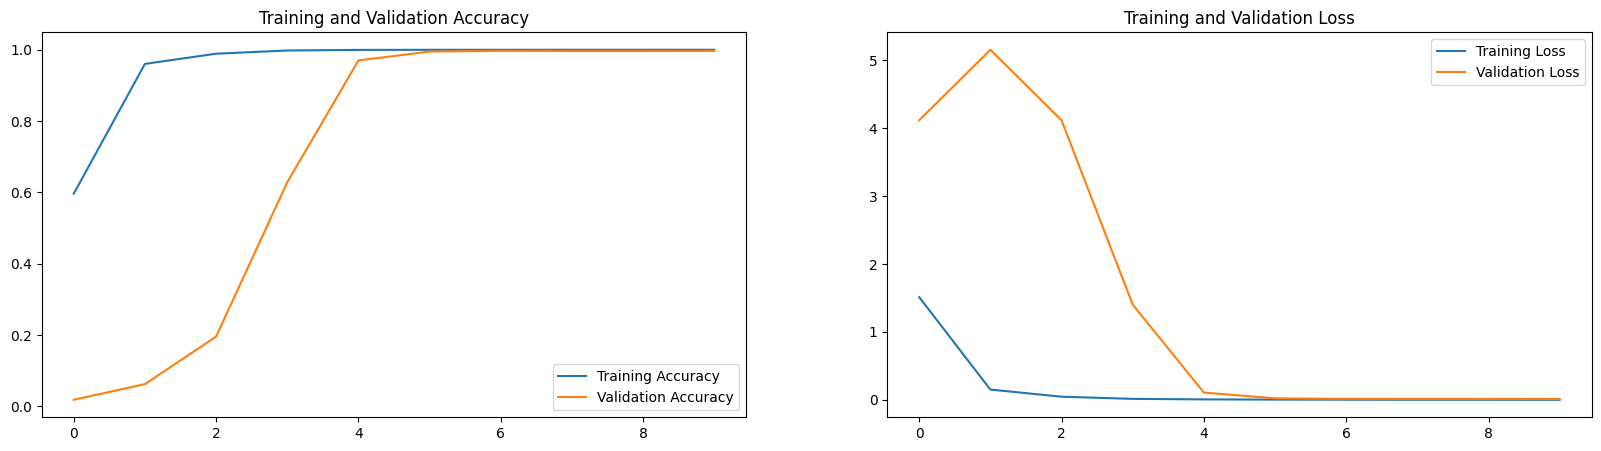

In [37]:
# Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [127]:
# Predictions on the test set
predictions = []
# reading the CSV file
test_csv = pd.read_csv('/content/GTSRB_dataset/Test.csv')
test_img_paths = test_csv["Path"].values
test_labels = test_csv["ClassId"].values
int_test_labels = [int(label) for label in test_labels]
cnt = 0
ok_pred = 0
test_images = []

for test_img_path in test_img_paths:
  test_img = tf.keras.utils.load_img(DATASET_PATH + '/' + test_img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img_array = tf.keras.utils.img_to_array(test_img)
  test_images.append(img_array)
  img_array = np.array(tf.expand_dims(img_array, 0)) # Create a batch (TF expects a batch)
  curr_pred = model.predict(img_array, verbose = 0)
  score = tf.nn.softmax(curr_pred[0])
  pred = int(train_ds.class_names[np.argmax(score)])
  predictions.append(pred)
  correct_label = int_test_labels[cnt]
  if pred == correct_label:
    ok_pred +=1
  cnt+=1
  if cnt == 101:
    break
acc = (ok_pred/cnt)*100
print("Accuracy on {} test images is: {:.5f}%." .format(cnt,acc))
#print("Predicted class: ", classes[int(train_ds.class_names[np.argmax(score)])])
#print("Correct label: ", test_labels[cnt])


# Loading test data
# test_ds = []

# for img in test_img_paths:
#   image = tf.keras.utils.load_img(DATASET_PATH + '/' + img, target_size=(IMG_HEIGHT, IMG_WIDTH))
#   img_array = tf.keras.utils.img_to_array(image)
#   test_ds.append(np.array(img_array))

# X_test = np.array(test_ds)

loss, accuracy = model.evaluate(test_ds, batch_size=128)
print("Loss: {}, accuracy: {:.5f}% on test images." .format(loss,accuracy*100))

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Accuracy on 101 test images is: 95.04950%.
 1417/12630 [==>...........................] - ETA: 3:26 - loss: 24.8723 - accuracy: 0.0586

KeyboardInterrupt: ignored

In [117]:
p = X_test[0]
p_batch = tf.expand_dims(p, 0)
preds = model.predict(p_batch)
score_X = tf.nn.softmax(preds)
predicted_labels = tf.argmax(score_X, axis=1)
print(predicted_labels)

1/1 [==============================] - 0s 45ms/step
tf.Tensor(
[[0.02256861 0.02256861 0.02256861 0.02256861 0.02256861 0.02256861
  0.02256861 0.02256861 0.04071857 0.02256861 0.02256861 0.02256861
  0.02256861 0.02256861 0.02256861 0.02256861 0.02256861 0.02256861
  0.02256861 0.02256861 0.02256861 0.02256861 0.02256861 0.02256861
  0.02256861 0.02256861 0.02256861 0.02256861 0.02256861 0.02256861
  0.02256861 0.02256861 0.02256861 0.02256861 0.02256861 0.02256861
  0.02256861 0.02256861 0.0226366  0.02256861 0.03390043 0.02256861
  0.02256861]], shape=(1, 43), dtype=float32)
tf.Tensor([8], shape=(1,), dtype=int64)


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [126]:
test_img = tf.keras.utils.load_img(DATASET_PATH + '/' + test_img_paths[0], target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.utils.img_to_array(test_img)
test_images.append(img_array)
img_arrays = np.array(tf.expand_dims(img_array, 0)) # Create a batch (TF expects a batch)
curr_pred = model.predict(img_arrays, verbose = 2)
print(curr_pred)
print(curr_pred[0])
score = tf.nn.softmax(curr_pred[0])
print("\n", score)
pred = int(np.argmax(score))
print(pred)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

print(softmax(curr_pred))

1/1 - 0s - 69ms/epoch - 69ms/step
[[2.73653279e-13 2.23875077e-14 8.99486374e-10 8.08617032e-21
  7.90508126e-24 1.08186307e-13 1.62956561e-15 6.76024503e-13
  5.90124249e-01 1.99572191e-18 1.09516322e-20 1.59386705e-19
  2.76751668e-14 1.25858929e-19 2.89187068e-21 2.11157988e-26
  2.46711819e-16 9.67429812e-21 2.11112608e-21 1.03902466e-22
  4.49736639e-23 1.71352774e-20 7.75002891e-23 2.80930959e-13
  8.51695558e-19 6.29530571e-21 3.65667862e-17 9.64723080e-17
  1.00860711e-21 1.30771297e-19 1.92331457e-16 6.86025805e-22
  2.05154937e-15 4.84116137e-21 4.40275507e-12 3.29077991e-17
  3.41167117e-13 8.79348070e-12 3.00807809e-03 6.92062239e-14
  4.06867623e-01 1.51345536e-09 1.99023162e-08]]
2.7365328e-13

 tf.Tensor(
[0.02256861 0.02256861 0.02256861 0.02256861 0.02256861 0.02256861
 0.02256861 0.02256861 0.04071857 0.02256861 0.02256861 0.02256861
 0.02256861 0.02256861 0.02256861 0.02256861 0.02256861 0.02256861
 0.02256861 0.02256861 0.02256861 0.02256861 0.02256861 0.02256861
 0

In [15]:
# Freezing layers for the training on augmented data
def freeze_model(model):
  for layer in model.layers:
      layer.trainable = False
  for layer in model.layers[-4:]:
      layer.trainable = True
      
  model.layers[-2].rate = 0.0  # lessened dropout rate

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
freeze_model(model)

In [21]:
# Transfer learning with augmented data
epochs=10
historyTR = model.fit(
  train_ds_aug,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True)

Epoch 1/10
123/123 [==============================] - 23s 177ms/step - loss: 0.4284 - accuracy: 0.9027 - val_loss: 0.1541 - val_accuracy: 0.9614
Epoch 2/10
123/123 [==============================] - 21s 170ms/step - loss: 0.1971 - accuracy: 0.9460 - val_loss: 0.1879 - val_accuracy: 0.9546
Epoch 3/10
123/123 [==============================] - 20s 163ms/step - loss: 0.1617 - accuracy: 0.9535 - val_loss: 0.2154 - val_accuracy: 0.9472
Epoch 4/10
123/123 [==============================] - 27s 217ms/step - loss: 0.1375 - accuracy: 0.9611 - val_loss: 0.2549 - val_accuracy: 0.9413
Epoch 5/10
123/123 [==============================] - 22s 172ms/step - loss: 0.1411 - accuracy: 0.9592 - val_loss: 0.2504 - val_accuracy: 0.9387
Epoch 6/10
123/123 [==============================] - 21s 164ms/step - loss: 0.1072 - accuracy: 0.9693 - val_loss: 0.3310 - val_accuracy: 0.9268
Epoch 7/10
123/123 [==============================] - 22s 174ms/step - loss: 0.1163 - accuracy: 0.9672 - val_loss: 0.2610 - val_ac

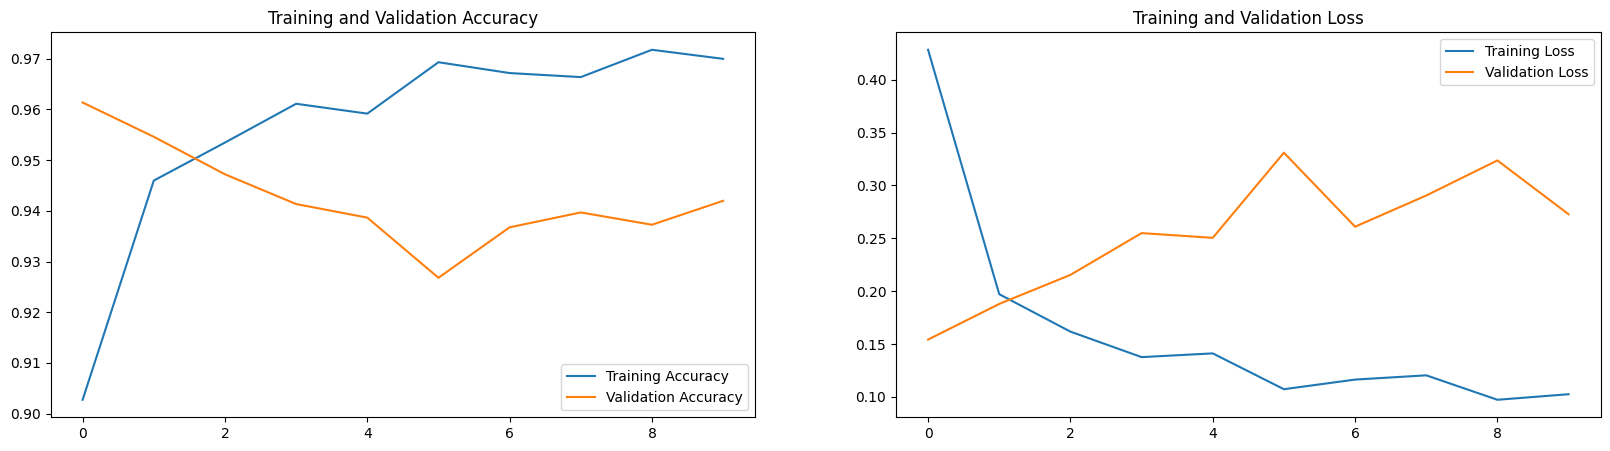

In [22]:
# Visualizing the results
acc = historyTR.history['accuracy']
val_acc = historyTR.history['val_accuracy']

loss = historyTR.history['loss']
val_loss = historyTR.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
from tensorflow.python.training.saver import metrics
# reading the CSV file
test_csv = pd.read_csv('/content/GTSRB_dataset/Test.csv')
test_img_paths = test_csv["Path"].values
test_labels = test_csv["ClassId"].values
int_test_labels = [int(label) for label in test_labels]
cnt = 0
ok_pred = 0
test_images = []
# Loading test data
test_ds = []

for img in test_img_paths:
  image = tf.keras.utils.load_img(DATASET_PATH + '/' + img, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img_array = tf.keras.utils.img_to_array(image)
  test_ds.append(np.array(img_array))

X_test = np.array(test_ds)

loss, accuracy = model.evaluate(X_test, test_labels, batch_size=TEST_BATCH_SIZE)
print("Loss: {}, accuracy: {:.5f}% on test images." .format(loss,accuracy*100))

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


50/50 [==============================] - 2s 38ms/step - loss: 34.5365 - accuracy: 0.0529
Loss: 34.53645324707031, accuracy: 5.28899% on test images.


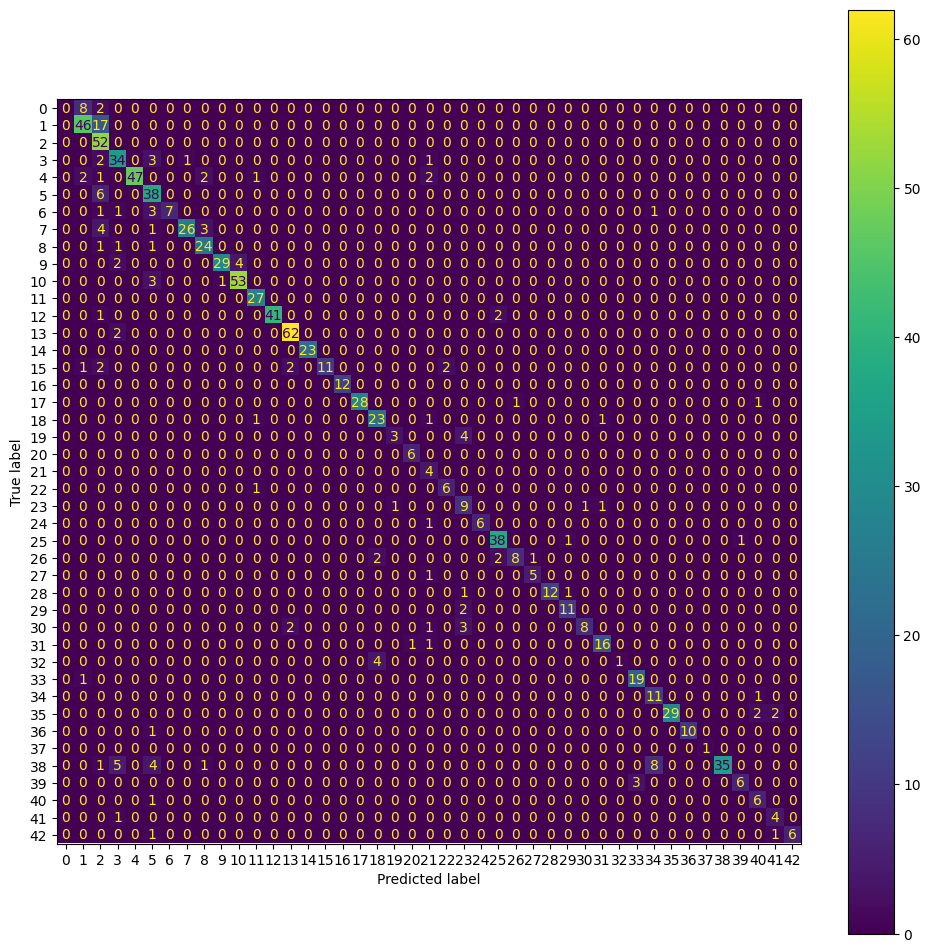

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_labels_short = test_labels[:1001]
cm = confusion_matrix(test_labels_short, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
fig = disp.figure_
fig.set_figwidth(12)
fig.set_figheight(12) 
plt.show()

In [27]:
from sklearn.metrics import classification_report

print(classification_report(test_labels[:1001], predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.79      0.73      0.76        63
           2       0.58      1.00      0.73        52
           3       0.74      0.83      0.78        41
           4       1.00      0.85      0.92        55
           5       0.68      0.86      0.76        44
           6       1.00      0.54      0.70        13
           7       0.96      0.76      0.85        34
           8       0.80      0.89      0.84        27
           9       0.97      0.83      0.89        35
          10       0.93      0.93      0.93        57
          11       0.90      1.00      0.95        27
          12       1.00      0.93      0.96        44
          13       0.94      0.97      0.95        64
          14       1.00      1.00      1.00        23
          15       1.00      0.61      0.76        18
          16       1.00      1.00      1.00        12
          17       1.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


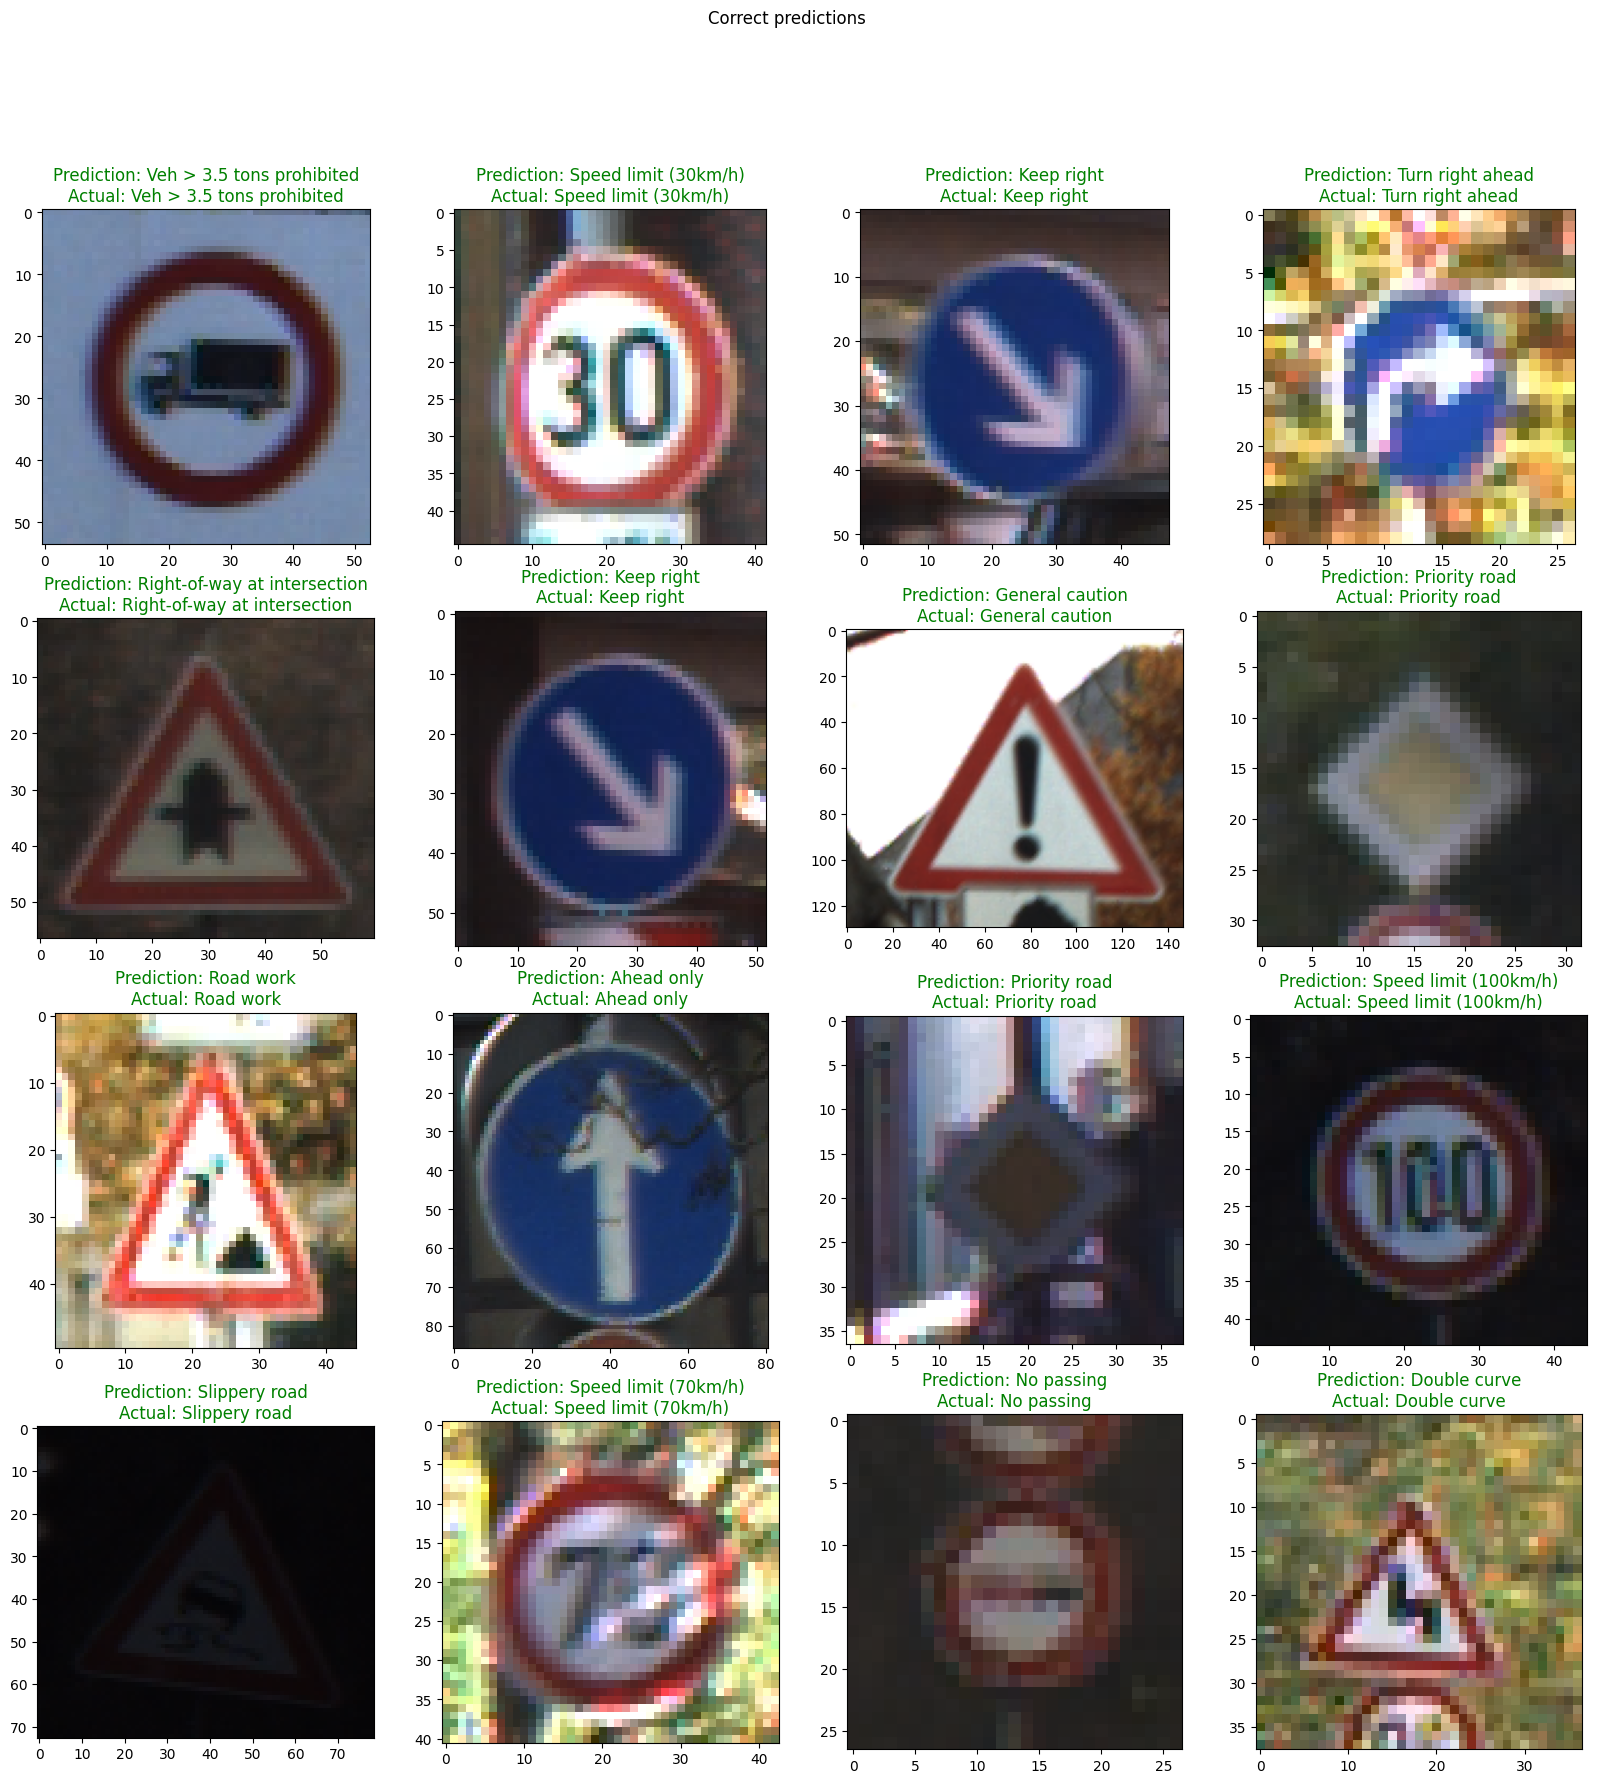

In [28]:
# Showing correct prediction examples
fig_correct = plt.figure(figsize=(20, 20))
fig_correct.suptitle("Correct predictions")
plt_cnt = 1
label_cnt = 0

for prediction in predictions:
  if prediction == int_test_labels[label_cnt]:
    test_img_path = test_img_paths[label_cnt]
    test_img = tf.keras.utils.load_img(DATASET_PATH + '/' + test_img_path)
    img_array = tf.keras.utils.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0)
    ax = fig_correct.add_subplot(4, 4, plt_cnt)
    ax.set_title(str("Prediction: {}\nActual: {}".format(classes[prediction],classes[test_labels[label_cnt]])), color = 'g')
    plt.imshow(test_img)
    plt_cnt += 1
  label_cnt +=1
  if plt_cnt == 17:
    break
plt.show()

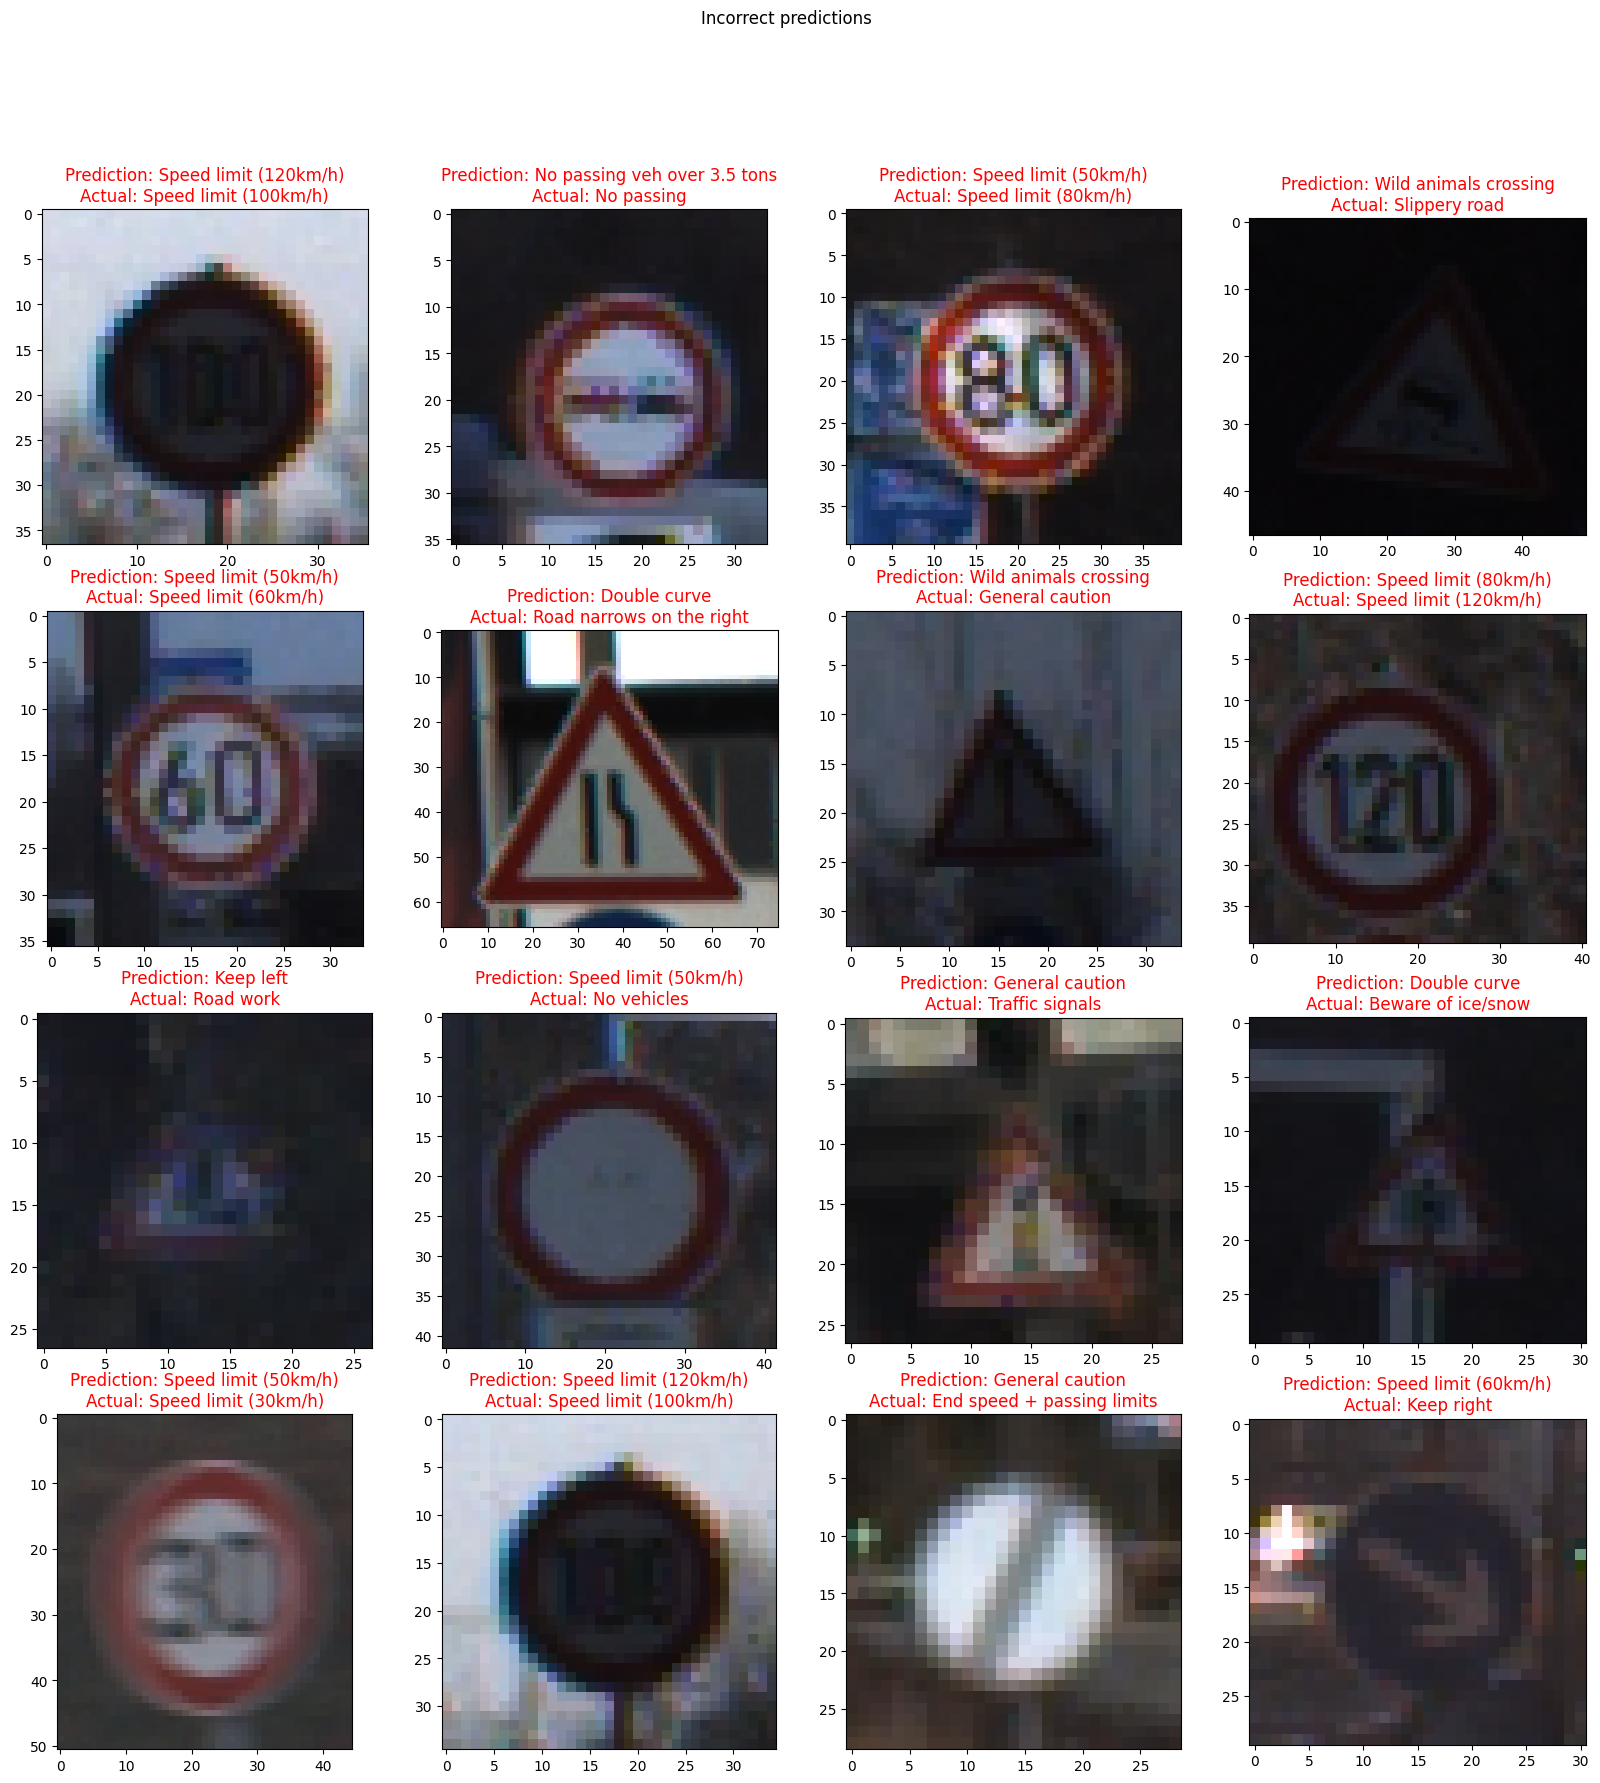

In [29]:
# Showing incorrect prediction examples
fig_correct = plt.figure(figsize=(20, 20))
fig_correct.suptitle("Incorrect predictions")
plt_cnt = 1
label_cnt = 0

for prediction in predictions:
  if prediction != int_test_labels[label_cnt]:
    test_img_path = test_img_paths[label_cnt]
    test_img = tf.keras.utils.load_img(DATASET_PATH + '/' + test_img_path)
    img_array = tf.keras.utils.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0)
    ax = fig_correct.add_subplot(4, 4, plt_cnt)
    ax.set_title(str("Prediction: {}\nActual: {}".format(classes[prediction],classes[test_labels[label_cnt]])), color = 'r')
    plt.imshow(test_img)
    plt_cnt += 1
  label_cnt +=1
  if plt_cnt == 17:
    break
plt.show()